In [1]:
import os
import sys
from pathlib import Path
import warnings
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import yaml
import importlib
import numpy as np
import gvar as gv
import platform
import pprint
# import lsqfitics
cwd = Path(os.getcwd())
# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)
# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels
# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

# local imports 
import xpt.fit_analysis as xfa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.plots as plots
warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')
# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd'
else:
    base_dir = '/home/gmoney/lqcd'

data_dir = os.path.join(base_dir, "data")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")


/home/gmoney/lqcd/hyperon-xpt-master


In [2]:
from importlib import reload
reload(xfa)
reload(i_o)
reload(fit)
reload(priors)

<module 'xpt.priors' from '/home/gmoney/lqcd/hyperon-xpt-master/xpt/priors.py'>

In [3]:
gv.load('../scale_setting.p')

{'w0_org:a06': 2.986(12),
 'w0_org:a09': 1.9443(55),
 'w0_org:a12': 1.4107(29),
 'w0_org:a15': 1.1451(12),
 'w0_org:w0': 0.1713(12),
 't0_org:a06': 6.587(25),
 't0_org:a09': 3.0382(77),
 't0_org:a12': 1.7570(33),
 't0_org:a15': 1.2376(16),
 't0_org:sqrt_t0': 0.1414(12),
 'w0_imp:a06': 2.997(12),
 'w0_imp:a09': 1.9556(54),
 'w0_imp:a12': 1.4163(29),
 'w0_imp:a15': 1.1341(15),
 'w0_imp:w0': 0.1716(12),
 't0_imp:a06': 6.234(26),
 't0_imp:a09': 2.7139(80),
 't0_imp:a12': 1.4693(32),
 't0_imp:a15': 0.9920(13),
 't0_imp:sqrt_t0': 0.1418(11),
 'meta': {'original_scales': '2023_06_20-original_simultaneous',
  'improved_scales': '2023_06_20-improved_simultaneous'}}

In [4]:
# gv.load('../scale_setting.p')
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
lam_sigma_models = models['models']['lam_sigma_system']

In [5]:
prior = priors.get_prior(units='mev')
input_output = i_o.InputOutput(project_path=data_dir)
data, ensembles = input_output.get_data(units='phys')
new_prior = input_output.make_prior(data=data,prior=prior)
phys_point_data = input_output.get_data_phys_point()
data

{'m_lambda': array([1255(12), 1062(26), 1142(11), 1229(10), 1260(10), 1304(11),
        1090(11), 1123.8(9.5), 1187.4(9.1), 1213.6(9.9), 1252.6(9.7),
        1065(10), 1103.0(7.9), 1162.8(8.9), 1156.7(8.7), 1180.1(8.9),
        1228.1(8.7)], dtype=object),
 'm_sigma': array([1311(13), 1201(10), 1215(13), 1291(11), 1312(12), 1347(12),
        1186.3(9.6), 1208.7(9.2), 1248.0(9.6), 1275.2(9.7), 1298(10),
        1206(10), 1194.5(8.9), 1236.8(8.3), 1229.1(9.2), 1237.6(9.5),
        1280.5(9.0)], dtype=object),
 'm_sigma_st': array([1504(28), 1423(23), 1461(23), 1541(26), 1573(22), 1601(17),
        1462(14), 1480(12), 1507(17), 1536(16), 1558(17), 1485(13),
        1447(23), 1499(10), 1499(11), 1490(21), 1537(13)], dtype=object),
 'm_xi_st': array([1643(18), 1527(16), 1563(19), 1620(21), 1631(27), 1671(15),
        1535(13), 1555(12), 1581(13), 1599(14), 1622(13), 1528(11),
        1518(13), 1557(10), 1554(11), 1555(13), 1584(13)], dtype=object),
 'm_xi': array([1410(13), 1282(12), 1318(1

## Xi, Xi* system in physical units with scale setting ## 

In [10]:
reload(xfa)
compare = xfa.ModelComparsion(verbose=True, phys_point_data=phys_point_data,
                                data=data, models=xi_models, prior=new_prior,project_path=data_dir)
# compare.model_plots(system='xi')

## Xi, Xi* system in fpi units without scale setting ## 


In [7]:
prior_fpi = priors.get_prior(units='lam_chi')
input_output = i_o.InputOutput(project_path=data_dir)
data_units_fpi,ensembles = input_output.get_data(units='fpi')
new_prior_fpi = input_output.make_prior(data=data_units_fpi,prior=prior_fpi)
data_units_fpi


{'m_lambda': array([0.3619(16), 0.470(11), 0.5051(30), 0.5436(16), 0.5575(12),
        0.5767(20), 0.6666(49), 0.6872(30), 0.7261(16), 0.7421(27),
        0.7659(19), 0.8126(57), 0.8413(22), 0.8868(34), 0.8822(31),
        0.9000(32), 0.9366(24)], dtype=object),
 'm_sigma': array([0.3782(19), 0.5315(14), 0.5377(40), 0.5712(20), 0.5806(22),
        0.5958(20), 0.7254(25), 0.7391(17), 0.7631(19), 0.7798(16),
        0.7936(19), 0.9198(51), 0.9111(31), 0.9433(11), 0.9374(32),
        0.9439(37), 0.9766(22)], dtype=object),
 'm_sigma_st': array([0.4336(71), 0.6294(87), 0.6463(85), 0.682(10), 0.6960(80),
        0.7084(46), 0.8940(59), 0.9051(26), 0.9217(83), 0.9392(68),
        0.9525(78), 1.1328(62), 1.104(16), 1.1430(18), 1.1434(29),
        1.137(14), 1.1721(63)], dtype=object),
 'm_xi_st': array([0.4738(31), 0.6755(43), 0.6916(65), 0.7166(72), 0.721(10),
        0.7394(28), 0.9388(40), 0.9511(17), 0.9667(43), 0.9775(50),
        0.9918(36), 1.1650(34), 1.1580(60), 1.1876(11), 1.1855(23

In [8]:
reload(xfa)
for mdl_key in xi_models:
    xi_models[mdl_key]['units'] = 'fpi'
    model_info_ = xi_models[mdl_key]
    xfa_instance = xfa.Xpt_Fit_Analysis(phys_point_data=phys_point_data, data=data_units_fpi, 
                                            model_info=model_info_, prior=prior_fpi, 
                                            project_path=data_dir, verbose=False,extrapolate=False)
    print(xfa_instance)

Model: xi:xi_st:d_n2lo:l_lo
---

Error Budget:
xi
  stat    99.8%
  disc     0.8%
  pp       0.1%
  chiral   0.1%
xi_st
  stat    99.9%
  disc     1.6%
  chiral   0.0%
  pp       0.0%
Least Square Fit:
  chi2/dof [dof] = 4.2 [34]    Q = 2.3e-15    logGBF = 45.885

Parameters:
       m_{xi,0}     1.1391 (66)      [     1.0 (1.0) ]  
         s_{xi}     -0.899 (75)      [     0.0 (2.0) ]  
       d_{xi,a}     -0.531 (82)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.10 (28)      [     2.0 (4.0) ]  
      d_{xi,al}       1.15 (48)      [     0.0 (5.0) ]  
    m_{xi_st,0}      1.242 (10)      [     1.1 (1.0) ]  
     s_{xi,bar}      1e-16 +- 2      [     0.0 (2.0) ]  
    d_{xi_st,a}       0.62 (15)      [     0.0 (2.0) ]  
   d_{xi_st,aa}      -0.98 (53)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -6.55 (33)      [     0.0 (5.0) ]  *
       eps2_a 1   0.065326 (70)      [ 0.065325 (70) ]  
              5    0.07161 (20)      [  0.07160 (20) ]  
             12    0.19738 (28)      [

RuntimeError: latex was not able to process the following string:
b"1221(15)}, 'sigma_st': {'sigma_pi': 58.0(7.7), 'mass': 1402(26)}} ---  Error"

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp2rvf0mwk 03e7e0d72823581f42b9f6d86e23c603.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./03e7e0d72823581f42b9f6d86e23c603.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 03e7e0d72823581f42b9f6d86e23c603.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Too many }'s.
l.29 ...{'sigma_pi': 58.0(7.7), 'mass': 1402(26)}}
                                                   ---  Error}%
No pages of output.
Transcript written on tmp2rvf0mwk/03e7e0d72823581f42b9f6d86e23c603.log.




Error in callback <function _draw_all_if_interactive at 0x7f0c14cb23e0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b"1221(15)}, 'sigma_st': {'sigma_pi': 58.0(7.7), 'mass': 1402(26)}} ---  Error"

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpy84ojlfq 03e7e0d72823581f42b9f6d86e23c603.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./03e7e0d72823581f42b9f6d86e23c603.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 03e7e0d72823581f42b9f6d86e23c603.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Too many }'s.
l.29 ...{'sigma_pi': 58.0(7.7), 'mass': 1402(26)}}
                                                   ---  Error}%
No pages of output.
Transcript written on tmpy84ojlfq/03e7e0d72823581f42b9f6d86e23c603.log.




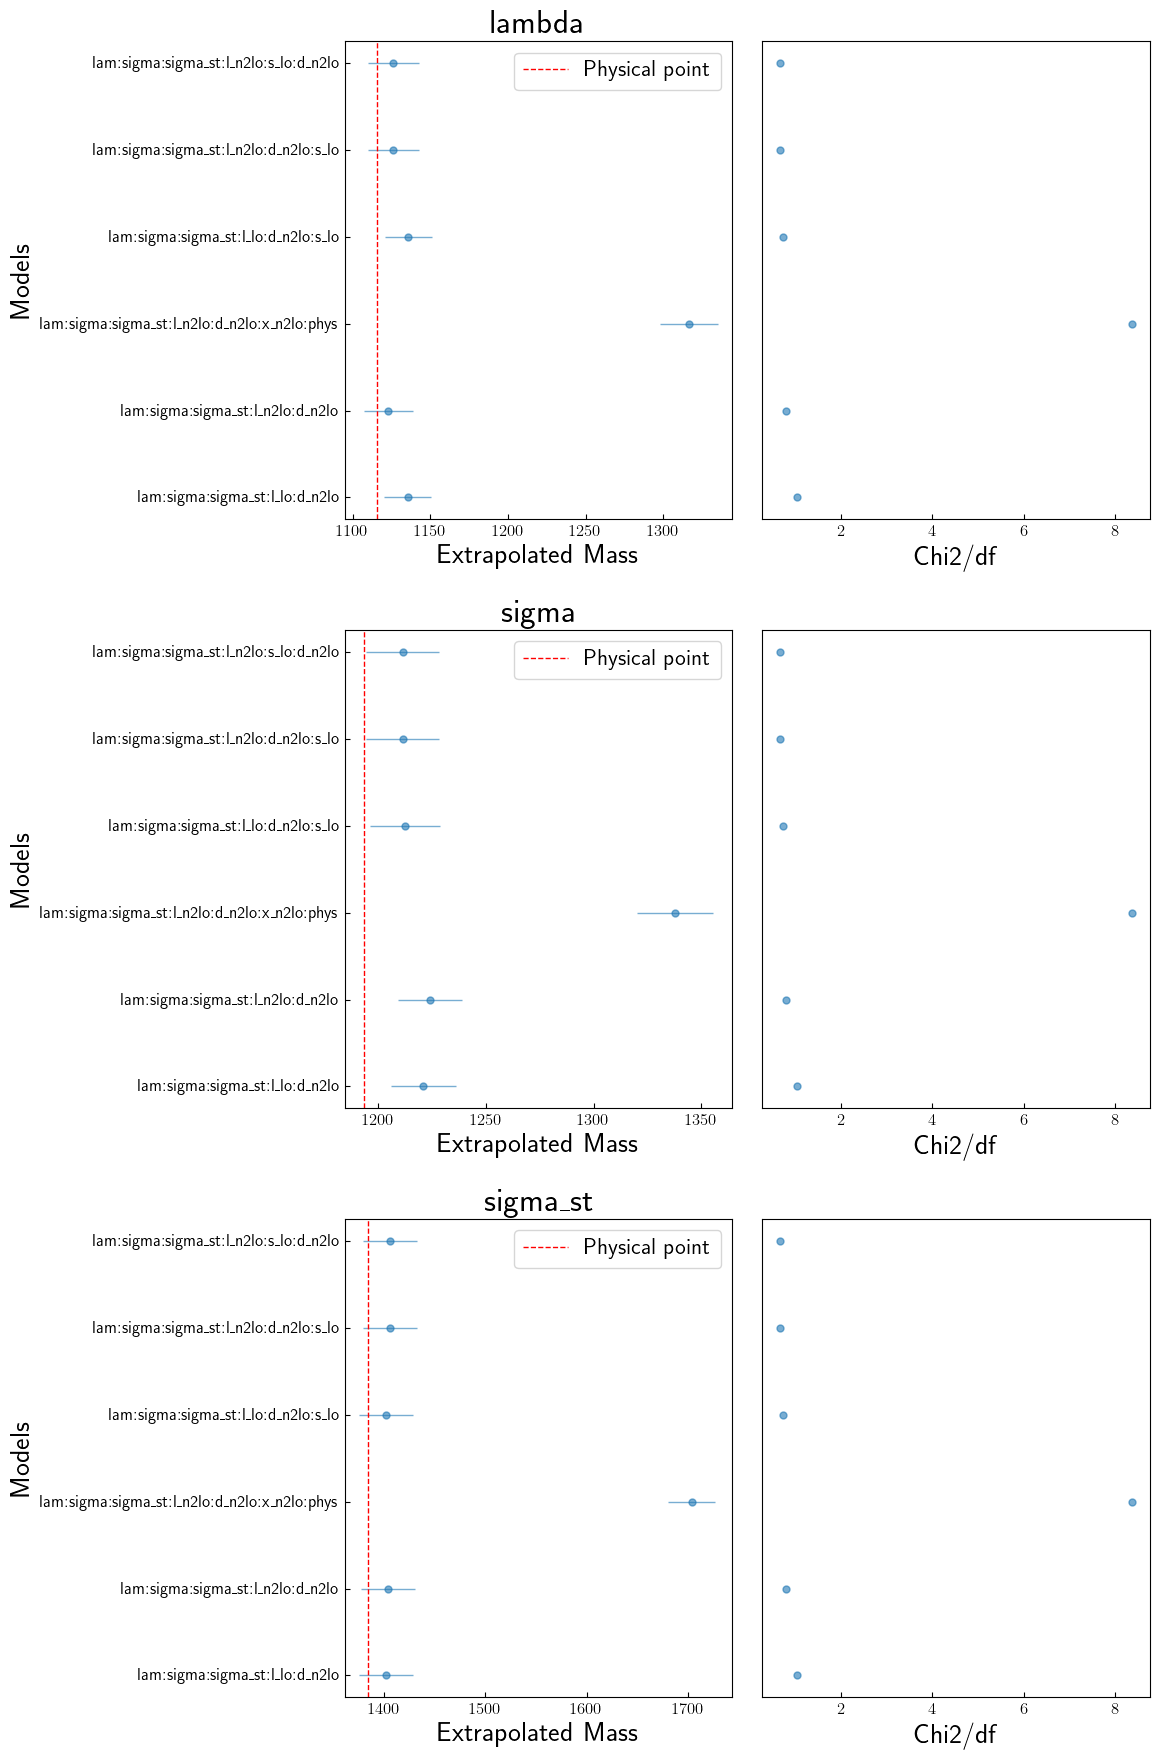

RuntimeError: latex was not able to process the following string:
b"1221(15)}, 'sigma_st': {'sigma_pi': 58.0(7.7), 'mass': 1402(26)}} ---  Error"

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpqw7prbsk 03e7e0d72823581f42b9f6d86e23c603.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./03e7e0d72823581f42b9f6d86e23c603.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 03e7e0d72823581f42b9f6d86e23c603.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Too many }'s.
l.29 ...{'sigma_pi': 58.0(7.7), 'mass': 1402(26)}}
                                                   ---  Error}%
No pages of output.
Transcript written on tmpqw7prbsk/03e7e0d72823581f42b9f6d86e23c603.log.




<Figure size 1000x1000 with 1 Axes>

In [9]:
reload(xfa)
reload(fit)
import lsqfitics
for mdl_key in lam_sigma_models:
    model_info_ = lam_sigma_models[mdl_key]
    # try:
    extrap_analysis_lam = xfa.Xpt_Fit_Analysis(verbose=True, phys_point_data=phys_point_data,
                            data=data, model_info=model_info_, prior=new_prior,project_path=data_dir)
    fit_out_lam = extrap_analysis_lam.fit
#     # print(fit_out_lam)
#     print(extrap_analysis_lam)
    # except Exception as e:
    #     print(f"Error encountered for Model: {mdl_key}")
    #     print(f"Error details: {e}")
    #     continue
    
# extrap_analysis.plot_params(xparam='mpi_sq',observables='xi',show_plot=True,units='gev')
extrap_analysis_lam.plot_params(xparam='eps2_a',observables=['lambda','sigma','sigma_st'],show_plot=True,eps=False)
    # extrap_analysis.plot_params_fit(param='a',observable='xi',eps=False)
# extrap_analysis.plot_params_fit(param='mpi_sq',observable='xi')

'''model average with lsqfitics'''
# y_fit_ = extrap_analysis.extrapolation()
# print(y_fit_)

compare = xfa.ModelComparsion(verbose=True, phys_point_data=phys_point_data,
                                data=data, models=lam_sigma_models, prior=new_prior,project_path=data_dir)
compare.compare_models(particles=['lambda','sigma','sigma_st'])
compare.model_average(particles=['lambda','sigma','sigma_st'])
compare.model_plots()

In [ ]:
# model_info_fpi = xi_models['xi:xi_st:d_n2lo:l_n2lo:x_n2lo:fpi']
# # fpi units # 
# xi_fit_fpi = fit.FitRoutine(prior=prior_fpi,data=data_units_fpi, project_path=data_dir,model_info=model_info_fpi,
#                     phys_point_data=phys_point_data, emp_bayes=None,empbayes_grouping=None)
# # print(xi_fit_fpi)
# # print(xi_fit_fpi.extrapolation(observables=['sigma_pi','mass'],data=phys_point_data))
# extrap_analysis_fpi = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
#                                 data=data_units_fpi, model_info=model_info_fpi, prior=new_prior_fpi,project_path=data_dir)
# print(extrap_analysis_fpi)



### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation


In [ ]:
model_info_lam = lam_sigma_models['lam:sigma:sigma_st:l_n2lo:d_n2lo:x_n2lo:phys']
lam_fit = fit.FitRoutine(prior=prior,data=data, project_path=data_dir,model_info=model_info_lam,
                    phys_point_data=phys_point_data, emp_bayes=None,empbayes_grouping=None)

# print(lam_fit)
# print(lam_fit.extrapolation(observables=['sigma_pi','mass'],data=phys_point_data))

In [ ]:
reload(i_o)
xi_out = xi_fit.fit
m_pi = phys_point_data['m_pi']
lam_chi = phys_point_data['lam_chi']
m_proton = xi_out.p['m_{xi,0}']
e_pi = m_pi / lam_chi
# sigma = m_pi**2 *gv.deriv(m_proton, e_pi**2)
# print(sigma)
l3 = gv.gvar('3.53(26)')
l4 = gv.gvar('4.73(10)')
term_0 = lam_chi * e_pi/2 * m_proton
term_1 = lam_chi * e_pi/2 * m_proton * e_pi**2*(5/2 - l3/2 - 2*l4 )
term_2 = e_pi**2 * m_proton*(l4-1)
sigma = term_0 + term_1 + term_2
print(term_0,term_1,term_2,sigma)
# sigma_analytic = (e_pi/2 * (1 + e_pi**2*(5/2 - l3/2 - 2*l4 )) *m_proton_deriv) * lam_chi
print('sigma w/ gv.deriv:',sigma)
print('sigma analytic:',sigma_analytic)


NameError: name 'xi_fit' is not defined

In [ ]:

importlib.reload(xfa)
importlib.reload(fit)
importlib.reload(i_o)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior,project_path=data_dir)
    fit_out = extrap_analysis.fit
    for part in mdl_info['particles']:
        extrap_analysis.plot_params(observable=part,xparam='eps2_a',show_plot=True)
        print(f"Model: {mdl_key}")
        # print(fit_out)

    # print(extrap_analysis)

        # return fit_out

with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
for mdl_key in xi_models:
    # mdl_info = xi_models[mdl_key]
    try:
        perform_fit_and_plot(xi_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    


In [ ]:
from scipy.interpolate import interp1d
importlib.reload(xfa)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.fit_analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior)
    fit_out = extrap_analysis.fit
    print(fit_out)
    print(f"Model: {mdl_key}")
    print(extrap_analysis)

    # x_data = [gv.mean(x) for x in extrap_analysis.fit.p['eps2_a']]
    # for part in mdl_info['particles']:
    #     y_data = [gv.mean(y) for y in extrap_analysis.fit.y[part]]

    # y_fit = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')

    # x_fit = np.linspace(-0.1, 0.1, 100)
    # y_fit_vals = [y_fit(x) for x in x_fit]

    # plt.plot(x_fit, y_fit_vals, label=f"{mdl_key}")
    # plt.fill_between(x_fit, [y - gv.sdev(y) for y in y_fit_vals], [y + gv.sdev(y) for y in y_fit_vals], alpha=0.5)

    # plt.axvline(0, ls='--', color='black', label='phys. point')
    # y_phys = np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']])
    
    # plt.plot(0, gv.mean(y_phys), marker='o', mec='w', zorder=0.2, color='black')

    # plt.xlabel("$\epsilon_a^2$")
    # plt.ylabel("$m_\Xi(MeV)$")
    # plt.legend()
    # plt.grid()
    # plt.show()
    return fit_out


In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    try:
        perform_fit_and_plot(lam_sig_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    

In [ ]:
lam_sig_models = models['models']['lam_sigma_system']
model_info = lam_sig_models['lam:sigma:sigma_st:l_lo:d_n2lo:s_lo']
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
                                data=data,model_info=model_info,prior=new_prior)
lam_sigma_sys_out = my_fit.fit
plot_params(fit=lam_sigma_sys_out,yparam='lambda')

In [ ]:
lam_sigma_fit = perform_fit_and_plot(model_type=mod)
plot_params()

### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation

In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    perform_fit_and_plot(lam_sig_models,mdl_key)